## 95. サブワード化
<p>トークンの単位を単語や形態素からサブワードに変更し，91-94の実験を再度実施せよ．</p>

https://github.com/google/sentencepiece/blob/master/python/README.md

`pip install sentencepiece`

In [1]:
import sentencepiece as spm
import os
def create_spm(vocab_size, source="kyoto-train", directory="kftt-data-1.0/data/orig/"):
    directory = directory.rstrip('/')
    for lang in ["ja","en"]:
        if not os.path.exists(f'model_logs/{source}_{vocab_size}_{lang}.model'):
            spm.SentencePieceTrainer.train(input=f'{directory}/{source}.{lang}', 
                                           model_prefix=f'model_logs/{source}_{vocab_size}_{lang}', vocab_size=vocab_size)
    return f"{source}_{vocab_size}_ja.model", f"{source}_{vocab_size}_en.model"

In [2]:
def load_spm(vocab_size, source="kyoto-train"):
    sp_ja = spm.SentencePieceProcessor(model_file=f'model_logs/{source}_{vocab_size}_ja.model')
    sp_en = spm.SentencePieceProcessor(model_file=f'model_logs/{source}_{vocab_size}_en.model')
    return sp_ja, sp_en

In [3]:
if __name__ == '__main__':
    vocab_size = 13000
    create_spm(vocab_size)
    sp_ja, sp_en = load_spm(vocab_size)
    print(sp_ja.EncodeAsPieces('私の机はどこですか?'))
    print(sp_en.EncodeAsPieces("Yo ain't got your seat."))

['▁', '私', 'の', '机', 'は', 'どこ', 'で', 'す', 'か', '?']
['▁Yo', '▁a', 'in', "'", 't', '▁got', '▁your', '▁seat', '.']


In [4]:
def tokenize(sourcedir:str, targetdir:str, ja_nlp, en_nlp, tgtfiles=["kyoto-train","kyoto-dev","kyoto-test"]):
    sourcedir = sourcedir.rstrip('/')
    targetdir = targetdir.rstrip('/')
    import os; 
    os.makedirs(targetdir, exist_ok=True)
    for lang in ["ja","en"]:
        nlp = ja_nlp if lang == "ja" else en_nlp
        for file in tgtfiles:
            if os.path.exists(f"{targetdir}/{file}.{lang}"): 
                print(f'skipped: {sourcedir}/{file}.{lang} to {targetdir}/{file}.{lang}')
                continue
            with open(f"{sourcedir}/{file}.{lang}") as rf, open(f"{targetdir}/{file}.{lang}", "w") as wf:
                print(f'converting: {sourcedir}/{file}.{lang} to {targetdir}/{file}.{lang}')
                for i, line in enumerate(rf):
                    print(i, end="\r")
                    line = line.rstrip()
                    wf.write(" ".join(["[BOS]"]+[str(w) for w in nlp(line)]+["[EOS]"])+"\n")
                print(f'converted: {sourcedir}/{file}.{lang} to {targetdir}/{file}.{lang}')

In [5]:
def sp_tokenize(vocab_size, s_prefix="orig", source="kyoto-train", tgtfiles=["kyoto-train","kyoto-dev","kyoto-test"]):
    root = "kftt-data-1.0/data"
    outpath = f"{root}/{source}_{vocab_size}/"
    create_spm(vocab_size, source, f"{root}/{s_prefix}")
    ja_sp, en_sp = load_spm(vocab_size, source)
    tokenize(f"{root}/{s_prefix}", outpath, ja_sp.EncodeAsPieces, en_sp.EncodeAsPieces, tgtfiles)
    return outpath

In [6]:
if __name__ == '__main__':
    outpath = sp_tokenize(vocab_size)
    from DataAnalysis import DataAnalysis
    da = DataAnalysis(prepath=outpath)
    da.set("ja",["train"]).show_sentence_lengths()
    da.set("en",["train"]).show_sentence_lengths()

ja ['train']
  70%: datasize:28
  90%: datasize:45
  91%: datasize:46
  93%: datasize:50
  95%: datasize:54
  97%: datasize:62
  99%: datasize:78
 99.1%: datasize:80
 99.2%: datasize:82
 99.3%: datasize:84
 99.4%: datasize:86
 99.5%: datasize:89
 99.6%: datasize:93
 99.7%: datasize:98
 99.8%: datasize:105
 99.9%: datasize:119
 100%: datasize:222
en ['train']
  70%: datasize:37
  90%: datasize:60
  91%: datasize:62
  93%: datasize:67
  95%: datasize:74
  97%: datasize:84
  99%: datasize:107
 99.1%: datasize:109
 99.2%: datasize:112
 99.3%: datasize:115
 99.4%: datasize:119
 99.5%: datasize:123
 99.6%: datasize:129
 99.7%: datasize:136
 99.8%: datasize:147
 99.9%: datasize:166
 100%: datasize:290


In [7]:
def sp_load_dict(vocab_size, source="kyoto-train"):
    import pickle
    dics = {l:[] for l in ["ja","en"]}
    for lang in dics.keys():
        path = f'model_logs/{source}_{vocab_size}_{lang}'
        if os.path.exists(f'{path}.dic'): 
            with open(f'{path}.dic', 'rb') as f: dics[lang] = pickle.load(f)
            continue
        with open(f'{path}.vocab') as f:
            for line in f: 
                w = line.split()[0]
                if w in ["<unk>","<s>","</s>"]: continue
                dics[lang].append(w)
        dics[lang] = {w:i for i,w in enumerate(dics[lang],100)}
        for elm in [("[PAD]",0),("[BOS]",10),("[EOS]",11),("[UNK]",12)]:
            dics[lang][elm[0]] = elm[1]
        with open(f'{path}.dic', 'wb') as f: pickle.dump(dics[lang], f)
    return dics['ja'], dics['en']

In [8]:
if __name__ == '__main__':
    ja_dic, en_dic = sp_load_dict(13000)
    print(sorted(ja_dic.items(), key=lambda x:x[1])[:10])
    print(sorted(en_dic.items(), key=lambda x:x[1])[:10])

[('[PAD]', 0), ('[BOS]', 10), ('[EOS]', 11), ('[UNK]', 12), ('、', 100), ('。', 101), ('の', 102), ('▁', 103), (')', 104), ('(', 105)]
[('[PAD]', 0), ('[BOS]', 10), ('[EOS]', 11), ('[UNK]', 12), ('▁the', 100), (',', 101), ('▁of', 102), ('.', 103), ('▁and', 104), ('▁(', 105)]


In [ ]:
def idation(sourcedir, iddir, ja_dic, en_dic):
    if os.path.exists(iddir): return iddir
    os.makedirs(iddir)
    for path in os.listdir(sourcedir):
        lang = path[-2:]
        if   lang == "ja": dic = ja_dic
        elif lang == "en": dic = en_dic
        else: continue
        if os.path.exists(f"{iddir}/{path}"): continue
        with open(f"{sourcedir}/{path}") as rf, open(f"{iddir}/{path}","w") as wf:
            for line in rf:
                line = line.rstrip().split(" ")
                line = [w if w in dic else "[UNK]" for w in line]
                wf.write(" ".join([str(dic[w]) for w in line]) + "\n")
    return iddir

In [9]:
def sp_idation(vocab_size, source="kyoto-train"):  # idation means converting to id sequences
    sdir = f"kftt-data-1.0/data/{source}_{vocab_size}"
    idir = f"kftt-data-1.0/data/{source}_{vocab_size}_ids"
    ja_dic, en_dic = sp_load_dict(vocab_size, source)
    return idation(sdir, idir, ja_dic, en_dic)

In [10]:
if __name__ == '__main__':
    print(sp_idation(13000))

kftt-data-1.0/data/kyoto-train_13000_ids


In [11]:
if __name__ == '__main__':
    !jupyter nbconvert --to python Chapter10_95.ipynb

[NbConvertApp] Converting notebook Chapter10_95.ipynb to python
[NbConvertApp] Writing 10055 bytes to Chapter10_95.py


----

----

In [1]:
from fastai_model import get_param, get_elms
from Chapter10_91 import EarlyStopping, Print, Save, Tensorboard, BleuCallback
from Chapter10_91 import DataSet, Translator, Trainer, dataloader
import torch
from Chapter10_95 import load_spm, sp_tokenize, sp_load_dict, sp_idation

In [2]:
def subword_train(vocab_size, params, devicestr:str, tag:str="", s_prefix="orig", source="kyoto-train", 
                  examples=["私以外私じゃないの", "私は猫です。", "日本の水墨画を一変させた。"], 
                  tgtfiles=["kyoto-train","kyoto-dev","kyoto-test"], pretag="95"):
    sp_tokenize(vocab_size, source)
    sp_idation(vocab_size, source)
    ja_sp, en_sp = load_spm(vocab_size, source)
    ja_dic, en_dic = sp_load_dict(vocab_size, source)
    ja_dicsize, en_dicsize = max(ja_dic.values())+1, max(en_dic.values())+1
    model, optimizer, scheduler, device = get_elms(params, devicestr, ja_dicsize, en_dicsize)
    trainset = DataSet("train", maxlength=65, pathkey=f"{source}_{vocab_size}_ids")
    devset = DataSet("dev", maxlength=65, pathkey=f"{source}_{vocab_size}_ids")
    translator = Translator(ja_dic, en_dic, ja_sp.EncodeAsPieces, en_sp.EncodeAsPieces)

    from string import ascii_letters
    from random import choices
    def catseq_subword(seq):
        rand = '▁'+''.join(choices(ascii_letters,k=5))
        return ''.join([translator.en_dic_rev[s] if s!=12 else rand for s in seq]).replace('▁',' ').strip(' ')
    translator.out = catseq_subword
    
    bleu_cb = BleuCallback(catseq_subword)
    es_cb = EarlyStopping(count=10)
    save_cb = Save(model,f'model_logs/{pretag}_{vocab_size}_{tag}/')
    tb_cb = Tensorboard('./tb_logs/', f'{pretag}_{vocab_size}_{tag}', bleu_cb)
    print_cb = Print(model, translator, device, examples=examples, early_stopping=es_cb, bleu_callback=bleu_cb)
    callbacks = [es_cb,bleu_cb,save_cb,tb_cb,print_cb]
    trainer = Trainer(translator, trainset, devset, device=device)
    trainer.run(model, optimizer, epoch=300, device=device, batch_size=params['batch_size'], shuffle=True, scheduler=scheduler, callbacks=callbacks)

In [3]:
if __name__ == '__main__':
    batch_size = 64*2
    lrate_coef = 25000/batch_size*4
    params = get_param(d_model=512, lrate_coef=lrate_coef)
    params['batch_size'] = batch_size

In [10]:
if __name__ == '__main__':
    subword_train(20000, params, 'cuda:9', source="mix")

>10[  1/300]epoch: loss: 5.0675742, 3.6879359 | acc: 25.35663%, 38.58728% | bleu: 9.44869
   私以外私じゃないの　　　　	Among private private private private private private private private private private private private private private
   私は猫です。　　　　　　　	It is said that there is a story, which is said to be a
   日本の水墨画を一変させた。	It was in Japanese-style painting in Japanese-style painting in Japan,
>10[  2/300]epoch: loss: 2.8814800, 2.7638892 | acc: 46.76334%, 49.98919% | bleu: 15.95688
   私以外私じゃないの　　　　	Except for private private private privately, privately, it is a private
   私は猫です。　　　　　　　	I I I I I I I I I I I I I I I
   日本の水墨画を一変させた。	He made Nihon Suiku-kuboku-ga (Japanese ink)
>10[  3/300]epoch: loss: 2.3282777, 2.5380219 | acc: 53.96675%, 53.15824% | bleu: 18.72171
   私以外私じゃないの　　　　	Except private privately, you can't be able to do privately
   私は猫です。　　　　　　　	I I I I I I I I I I I I I I I
   日本の水墨画を一変させた。	He reformed Japanese Suibokuga (Japanese ink painting) which was
>10[  4/300]epoch: loss: 2.

### 20000

In [4]:
if __name__ == '__main__':
    subword_train(20000, params, 'cuda:9')

>10[  1/300]epoch: loss: 5.2360517, 3.9135925 | acc: 25.24341%, 34.73986% | bleu: 8.16796
   私以外私じゃないの　　　　	In many cases, there are not not not not not, not not not
   私は猫です。　　　　　　　	Jkciw  Jkciw is a  Jkciw.......
   日本の水墨画を一変させた。	The painting of the painting of the painting of the Japanese painting in Japan,
>10[  2/300]epoch: loss: 3.0872039, 2.9523217 | acc: 43.84442%, 46.05540% | bleu: 16.46564
   私以外私じゃないの　　　　	I don't other other other private.[EOS]
   私は猫です。　　　　　　　	I have a cat.[EOS]
   日本の水墨画を一変させた。	Japanese ink-wash painting in Japan changed his way to Japan.[EOS]
>10[  3/300]epoch: loss: 2.4801022, 2.6502910 | acc: 51.00823%, 49.93817% | bleu: 18.83018
   私以外私じゃないの　　　　	It is not private or not private.[EOS]
   私は猫です。　　　　　　　	I am a cat.[EOS]
   日本の水墨画を一変させた。	He changed Japanese ink-inkinkink Japanese ink painting.[EOS]
>10[  4/300]epoch: loss: 2.2208482, 2.5412091 | acc: 54.41079%, 51.89468% | bleu: 19.71357
   私以外私じゃないの　　　　	I don't I do not outside my private.[EOS]
   私は猫です。　　

----
### 15000

In [4]:
if __name__ == '__main__':
    subword_train(15000, params, 'cuda:9')

>10[  1/300]epoch: loss: 5.1497935, 3.8284648 | acc: 24.95181%, 35.31486% | bleu: 9.24235
   私以外私じゃないの　　　　	They are not not only, and are not not only, and there are
   私は猫です。　　　　　　　	He was a man, and was a man.[EOS]
   日本の水墨画を一変させた。	He made a painting painting on painting painting on painting on painting painting on the
>10[  2/300]epoch: loss: 3.0115155, 2.8524934 | acc: 44.15207%, 47.12298% | bleu: 16.50824
   私以外私じゃないの　　　　	He did not have any private children other than private children.[EOS]
   私は猫です。　　　　　　　	His private life is a cat.[EOS]
   日本の水墨画を一変させた。	The Sui Sui Sui Sui Sui Sui Sui Sui Sui Sui Sui Sui Sui Sui
>10[  3/300]epoch: loss: 2.4331299, 2.5850144 | acc: 51.32226%, 50.71039% | bleu: 18.84970
   私以外私じゃないの　　　　	No No No No No No No No No No No No No No No
   私は猫です。　　　　　　　	I had a cat.[EOS]
   日本の水墨画を一変させた。	He changed Japanese Suibokubokubokubokubokubokubokubokuboku in Japan
>10[  4/300]epoch: loss: 2.1836789, 2.4633236 | acc: 54.75365%, 52.79669% | bleu: 20.45558
   私以外私

----
### 10000

In [4]:
if __name__ == '__main__':
    subword_train(10000, params, 'cuda:9')

>10[  1/300]epoch: loss: 5.0258241, 3.6255219 | acc: 24.40052%, 35.83272% | bleu: 10.16723
   私以外私じゃないの　　　　	There are not a private private---------
   私は猫です。　　　　　　　	The private strains are syyy.[EOS]
   日本の水墨画を一変させた。	In Japan, Japan made a painting painting on Japanese ink painting in Japan,
>10[  2/300]epoch: loss: 2.9291404, 2.7169526 | acc: 44.31106%, 48.04219% | bleu: 16.80383
   私以外私じゃないの　　　　	I will not private private private private private private private private private private private private
   私は猫です。　　　　　　　	The private cat is a cat cat.[EOS]
   日本の水墨画を一変させた。	He changed the ink ink ink painting in Japan.[EOS]
>10[  3/300]epoch: loss: 2.3635384, 2.4574617 | acc: 51.92479%, 52.62554% | bleu: 19.15818
   私以外私じゃないの　　　　	I don't have private private private matters other than private.[EOS]
   私は猫です。　　　　　　　	I am a cat with a cat.[EOS]
   日本の水墨画を一変させた。	He changed Suiboku-ga (Chinese ink painting) in Japan.[EOS]
>10[  4/300]epoch: loss: 2.1227887, 2.3487369 | acc: 55.41209%, 54.2199

## Results

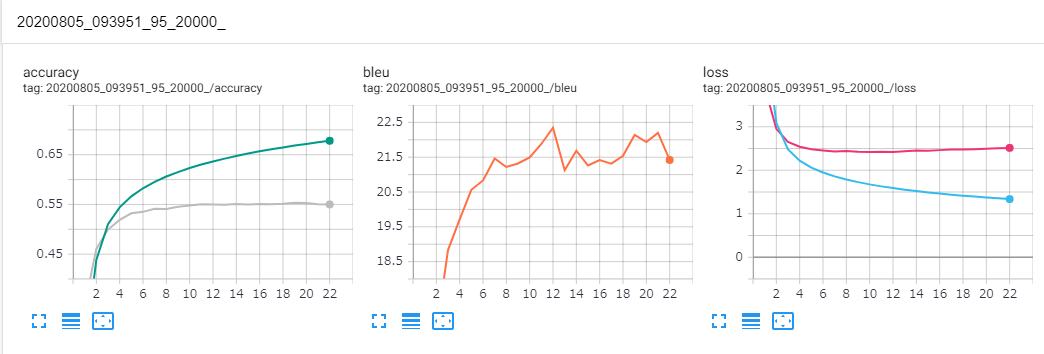

In [1]:
from IPython.display import Image
Image("imgs/20200805_093951_95_20000_.png")

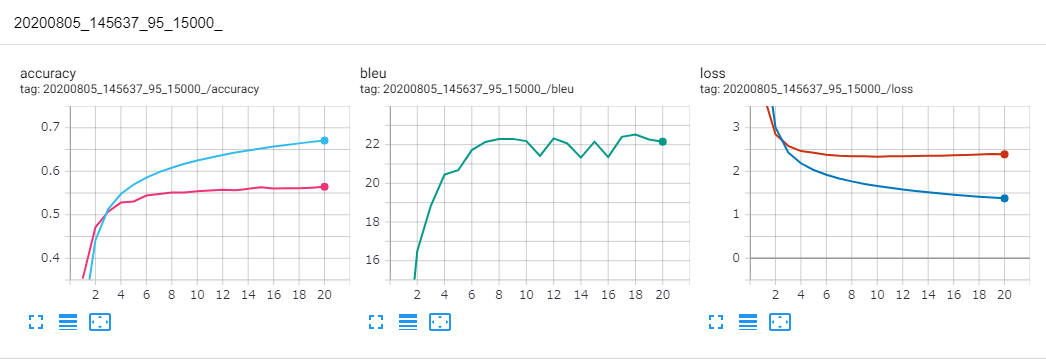

In [2]:
from IPython.display import Image
Image("imgs/20200805_145637_95_15000_.png")

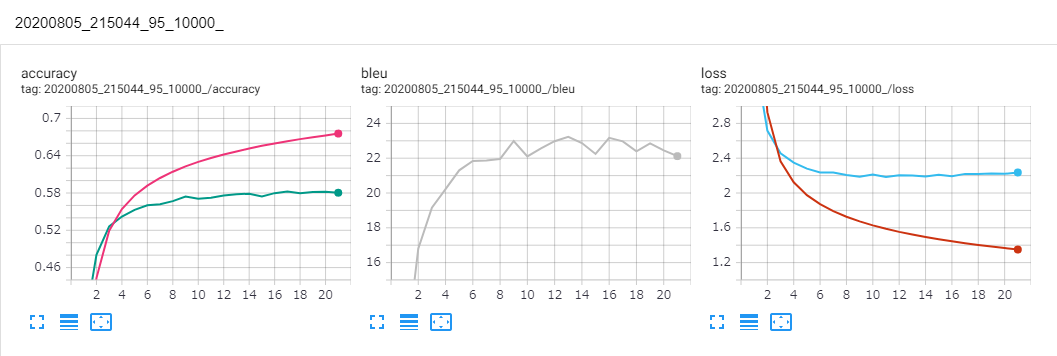

In [3]:
from IPython.display import Image
Image("imgs/20200805_215044_95_10000_.png")

In [4]:
if __name__ == '__main__':
    def get_bleu_scorer(vocab_size, source):
        ja_sp, en_sp = load_spm(vocab_size, source)
        ja_dic, en_dic = sp_load_dict(vocab_size, source)
        ja_dicsize, en_dicsize = max(ja_dic.values())+1, max(en_dic.values())+1
        devset = DataSet("dev", maxlength=65, pathkey=f"{source}_{vocab_size}_ids")
        translator = Translator(ja_dic, en_dic, ja_sp.EncodeAsPieces, en_sp.EncodeAsPieces)
        from Chapter10_93and94 import bleu_score
        from string import ascii_letters
        from random import choices
        def catseq_subword(seq):
            rand = '▁'+''.join(choices(ascii_letters,k=5))
            return ''.join([translator.en_dic_rev[s] if s!=12 else rand for s in seq]).replace('▁',' ').strip(' ')
        def _bleu_score(model, device, beam=1):
            return bleu_score(model, devset, translator, device=device, func=catseq_subword, beam=beam)
        return _bleu_score, ja_dicsize, en_dicsize

In [8]:
def bleu(vocab_size, source, modelpath):
    import matplotlib.pyplot as plt
    bleu_score, ja_dicsize, en_dicsize = get_bleu_scorer(vocab_size, source)
    model, _, _, device = get_elms(params, 'cuda:1', ja_dicsize, en_dicsize)
    model.load_state_dict(torch.load(modelpath, map_location=lambda storage, loc: storage))
    bleus = {}
    for i in list(range(1,10))+[20,25]:
        bleus[i] = bleu_score(model, device=device, beam=i)
    plt.plot(list(bleus.keys()), list(map(lambda x:x[0], bleus.values())))

cuda:9
42691713


beam= 25: 100%|██████████| 1103/1103 [1:00:40<00:00,  3.30s/it, beam=25	: bleu:17.49436133]


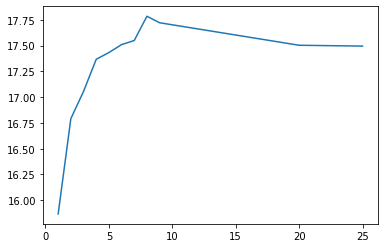

In [9]:
if __name__ == '__main__':
    bleu(20000, "kyoto-train", "model_logs/95_20000__20200805_093949/12_save.t7")

cuda:9
37566713


beam= 25: 100%|██████████| 1099/1099 [1:02:16<00:00,  3.40s/it, beam=25	: bleu:17.48153437]


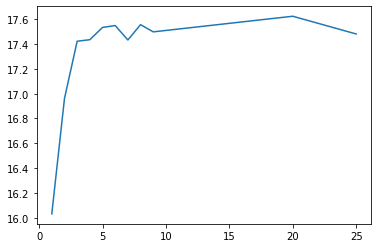

In [10]:
if __name__ == '__main__':
    bleu(15000, "kyoto-train", "model_logs/95_15000__20200805_145634/10_save.t7")

beam=  1:   0%|          | 0/1080 [00:00<?, ?it/s]

cuda:1
32441713


beam= 15: 100%|██████████| 1080/1080 [14:26<00:00,  1.25it/s, beam=15	: bleu:17.48171461]


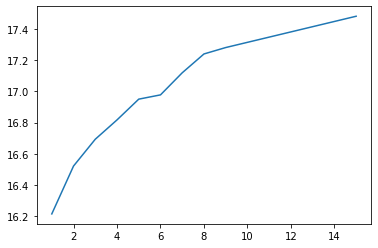

In [11]:
if __name__ == '__main__':
    bleu(10000, "kyoto-train", "model_logs/95_10000__20200805_215042/11_save.t7")